In [16]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy import stats
import json
from collections import defaultdict, Counter, namedtuple
from itertools import combinations
from tabulate import tabulate
import sys
import os
import json
import editdistance

PROJECT_PATH = '/Users/guydavidson/projects/game-generation-modeling'
sys.path.append(PROJECT_PATH)

In [17]:
d = {x: mpl.rcParams[x] for x in mpl.rcParams.keys() if x.startswith('text')}
d

{'text.antialiased': True,
 'text.color': 'black',
 'text.hinting': 'force_autohint',
 'text.hinting_factor': 8,
 'text.kerning_factor': 0,
 'text.latex.preamble': '',
 'text.latex.preview': False,
 'text.usetex': False}

## Load and munge data

In [18]:
from schema.validate_schema import load_and_validate_game_schema
SCHEMA_FILE = '../schema/game_schema_with_refs.json'
GAME_SCHEMAS_FILE = '../schema/interactive_beta.json'

In [19]:
def schema_to_df_row(game_schema):
    row = defaultdict(list)
    row.update(game_schema['metadata'])

    row['game_name'] = row['prolific_id']
    row['is_throwing'] = 0
    row['is_building'] = 0
    row['is_organizing'] = 0
    objects_with_predicates = []

    if 'throwing' in game_schema:
        throwing_game = game_schema['throwing']
        row['is_throwing'] = 1
        row['throwing_objects'] = throwing_game['what']
        row['throwing_goal'] = throwing_game['goal']
        
        for key in ('to', 'from', 'on'):
            if key in throwing_game:
                value = throwing_game[key]
                row[f'throwing_{key}'] = value
                objects_with_predicates.extend(value)

    if 'building' in game_schema:
        building_game = game_schema['building']
        row['is_building'] = 1
        row['building_objects'] = building_game['objects']
        row['building_goal'] = building_game['goal']
        row['building_structure'] = building_game['structure'] if 'structure' in building_game else None
        row['building_order'] = building_game['order'] if 'order' in building_game else None

        if 'on' in building_game:
            objects_with_predicates.append(building_game['on'])

    if 'organizing' in game_schema:
        row['is_organizing'] = 1
        row['organizing'] = game_schema['organizing']
        for org_game in game_schema['organizing']:
            row['organizing_objects'].extend(org_game['what'])
            if 'from' in org_game:
                objects_with_predicates.append(org_game['from'])
            objects_with_predicates.extend(org_game['to'])

    row['objects_with_predicates'] = objects_with_predicates

    return row


In [20]:
raw_stats_df = pd.read_csv('../data/dsl_statistics_interactive.csv', index_col='Index')
print(raw_stats_df.game_name.size - raw_stats_df.game_name.nunique())
print(raw_stats_df.shape)

game_schemas = load_and_validate_game_schema(GAME_SCHEMAS_FILE, SCHEMA_FILE)
game_schema_rows = [schema_to_df_row(game_schema) for game_schema in game_schemas]

schema_df = pd.DataFrame(game_schema_rows)
print(schema_df.prolific_id.size - schema_df.prolific_id.nunique())
print(schema_df.shape)
# manual_df = pd.read_csv('../data/manual_dsl_statistics.csv')
stats_df = raw_stats_df.merge(schema_df, on='game_name', copy=True)
print(stats_df.shape)

firestore_stats_df = pd.read_csv('../data/interactive_beta_firestore_statistics.csv')
firestore_stats_df = firestore_stats_df.rename(columns={key: key.replace('game_', 'raw_game_') for key in firestore_stats_df.columns if key.startswith('game_')})
firestore_stats_df = firestore_stats_df.rename(columns={key: key.replace('gameScore_', 'raw_game_') for key in firestore_stats_df.columns if key.startswith('gameScore_')})
print(firestore_stats_df.prolific_id.size - firestore_stats_df.prolific_id.nunique())
print(firestore_stats_df.shape)

stats_df = stats_df.merge(firestore_stats_df, on='prolific_id', copy=True)

stats_df.shape

0
(98, 14)
98
0
(98, 21)
(98, 34)
0
(113, 14)


(98, 47)

In [120]:
repeated_structures_df = pd.read_csv('../data/dsl_repeated_structures_temporal_operator.csv')
print(repeated_structures_df.shape)

print(repeated_structures_df.loc[87].structure, repeated_structures_df.loc[87, 'count'])
print(repeated_structures_df.loc[93].structure, repeated_structures_df.loc[93, 'count'])

repeated_structures_df.loc[87, 'count'] += repeated_structures_df.loc[93, 'count']
print(repeated_structures_df.loc[87].structure, repeated_structures_df.loc[87, 'count'])


repeated_structures_df = repeated_structures_df.drop(93, axis=0)
repeated_structures_df = repeated_structures_df.reindex()
print(repeated_structures_df.shape)

(134, 4)
(hold (and (not (agent_holds ?x) ) (in_motion ?x) ) ) 63
(hold (and (in_motion ?x) (not (agent_holds ?x) ) ) ) 47
(hold (and (not (agent_holds ?x) ) (in_motion ?x) ) ) 110
(133, 4)


In [22]:
stats_df.loc[stats_df.terminal_exists.isna(), 'terminal_exists'] = False

room = np.zeros((len(stats_df),), dtype=np.int32)
room[['medium' in d for d in stats_df.domain_name]] = 1
room[['many' in d for d in stats_df.domain_name]] = 2

room_name = ['Few'] * len(stats_df)
stats_df = stats_df.assign(room=room, room_name=room_name)

stats_df.loc[['medium' in d for d in stats_df.domain_name], 'room_name'] = 'Medium'
stats_df.loc[['many' in d for d in stats_df.domain_name], 'room_name'] = 'Many'

DIFFICULTIES = ('Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard')
stats_df = stats_df.assign(difficulty=[DIFFICULTIES[i] for i in stats_df.raw_game_difficulty])


stats_df.src_file = stats_df.src_file.apply(lambda s: s.replace('problems-', '').replace('.pddl', ''))
room[['interactive' in s for s in stats_df.src_file]] = 3
stats_df = stats_df.assign(src=room)

def list_from_text(list_text):
    if isinstance(list_text, str):
        return np.fromstring(list_text[1:-1], sep=',', dtype=np.int32)
    
    return []

stats_df = stats_df.assign(length_of_then=stats_df.length_of_then.apply(list_from_text))
stats_df = stats_df.assign(setup_objects_quantified=stats_df.setup_objects_quantified.apply(list_from_text))
stats_df = stats_df.assign(preference_objects_quantified=stats_df.preference_objects_quantified.apply(list_from_text))

def average_list_series(df, name):
    avg = np.empty_like(df[name])
    avg[:] = np.NaN
    for i, entry in df[name].iteritems():
        if len(entry) > 0:
            avg[i] = np.mean(entry)

    return df.assign(**{f'average_{name}': avg})

stats_df = average_list_series(stats_df, 'length_of_then')
stats_df = average_list_series(stats_df, 'setup_objects_quantified')
stats_df = average_list_series(stats_df, 'preference_objects_quantified')

GAME_TYPES = ('throwing', 'building', 'organizing')
game_type_data = [[type_name for type_name in GAME_TYPES if row[f'is_{type_name}']]
    for i, row in stats_df.iterrows()]


for col in stats_df.columns:
    if col.startswith('is_'):
        stats_df[col] = stats_df[col].astype('bool')


stats_df = stats_df.assign(game_type=game_type_data)
stats_df = stats_df.assign(game_type_str=['_'.join(sorted(types)) for types in stats_df.game_type])

def dict_from_str_with_key_filters(keys_to_filter):
    def inner(dict_str):
        d = json.loads(dict_str.replace("'",'"'))
        for key in keys_to_filter:
            if key in d:
                del d[key]

        return d

    return inner

OBJECT_TYPES_REFERENCED_KEYS_TO_FILTER = ('back', 'front', 'left', 'right', 'front_left_corner', 'upright', 'upside_down', 'sideways')

stats_df = stats_df.assign(object_types_referenced=stats_df.object_types_referenced.apply(dict_from_str_with_key_filters(OBJECT_TYPES_REFERENCED_KEYS_TO_FILTER)))
stats_df = stats_df.assign(predicates_referenced=stats_df.predicates_referenced.apply(dict_from_str_with_key_filters([])))
stats_df = stats_df.assign(type_to_pred_counts=stats_df.type_to_pred_counts.apply(dict_from_str_with_key_filters(OBJECT_TYPES_REFERENCED_KEYS_TO_FILTER)))

stats_df.loc[stats_df.edited_game_fields.isna(), 'edited_game_fields'] = ''
stats_df = stats_df.assign(edited_game_fields=[fields.split(',') if fields else '' for fields in stats_df.edited_game_fields])

    

In [23]:
all_types = set()
for type_dict in stats_df.object_types_referenced:
    all_types.update(type_dict.keys())

AGENT = 'agent'
ANY_OBJECT = 'any_object'
BALLS = 'balls'
BLOCKS = 'blocks'
BUILDING = 'building'
COLORS = 'colors'
EMPTY_OBJECT = 'empty_object'
FURNITURE = 'furniture'
LARGE_OBJCETS = 'large_objects'
MEDIUM_OBJECTS = 'medium_objects'
OTHER_OBJECTS = 'other_objects'
RAMPS = 'ramps'
RECEPTACLES = 'receptacles'
ROOM_FEATURES = 'room_features'
SMALL_OBJECTS = 'small_objects'


CATEGORIES_TO_TYPES = {
    AGENT: ('agent', ),
    ANY_OBJECT: ( 'game_object', ),
    BALLS: (
        'ball', 'basketball', 'beachball', 'blue_dodgeball', 'dodgeball',
        'golfball', 'green_golfball', 'pink_dodgeball', 'red_dodgeball',
    ),
    BLOCKS: (
        'block', 'bridge_block', 'cube_block', 'cylindrical_block', 
        'flat_block', 'pyramid_block', 'tall_cylindrical_block', 'triangle_block',
        'tan_cube_block', 'red_pyramid_block', 'blue_cube_block', 'blue_pyramid_block',
        'yellow_pyramid_block', 'yellow_cube_block', 
    ),
    COLORS: (
        'color', 'blue', 'brown', 'green', 'orange', 
        'pink', 'purple', 'red', 'tan', 'white', 'yellow', 
    ),
    EMPTY_OBJECT: ('',),
    FURNITURE: (
        'bed', 'blinds', 'chair', # TODO: does chair qualify as funiture? since it's movable
        'desk', 'desk_shelf', 'drawer', 'main_light_switch', 'desktop', 
        'top_drawer', 'side_table',
    ),
    BUILDING: (
        'building', 
    ),
    LARGE_OBJCETS: (
        'book', 'laptop', 'pillow', 'teddy_bear',
    ),
    RAMPS: ('curved_wooden_ramp',  'triangular_ramp',  'green_triangular_ramp'),
    RECEPTACLES: (
        'doggie_bed','hexagonal_bin', 
    ),
    ROOM_FEATURES: (
        'door', 'floor', 'rug', 'shelf', 'bottom_shelf', 'top_shelf', 'sliding_door',
        'east_sliding_door', 'south_west_corner', 'wall', 'north_wall',  'south_wall', 'west_wall',
    ),
    SMALL_OBJECTS: (
        'alarm_clock', 'cd', 'cellphone', 'credit_card', 
        'key_chain', 'lamp',  'mug', 'pen', 'pencil', 'watch',
    )
}

TYPES_TO_CATEGORIES = {type_name: cat for cat, type_names in CATEGORIES_TO_TYPES.items() for type_name in type_names}


for category_objects in CATEGORIES_TO_TYPES.values():
    for obj in category_objects:
        if obj not in all_types:
            print(f'Found unexpected type: "{obj}"')
        else:
            all_types.remove(obj)

if len(all_types) > 0:
    print(f'Found unaccounted types: {all_types}')


object_categories_referenced = []
object_categories_referenced_total = []

for object_to_count_dict in stats_df.object_types_referenced:
    refs = defaultdict(lambda: 0)
    total_refs = defaultdict(lambda: 0)

    for obj, count in object_to_count_dict.items():
        obj_type = TYPES_TO_CATEGORIES[obj]
        refs[obj_type] += 1
        total_refs[obj_type] += count

    object_categories_referenced.append(dict(refs))
    object_categories_referenced_total.append(dict(total_refs))

stats_df = stats_df.assign(object_categories_referenced=object_categories_referenced, object_categories_referenced_total=object_categories_referenced_total)

Found unexpected type: ""


In [24]:
FEW = 'Few'
MEDIUM = 'Medium'
MANY = 'Many'
ROOM_NAMES = (FEW, MEDIUM, MANY)


ROOMS_TO_AVAILABLE_OBJECTS = {
    FEW: set([
        'agent',
        'ball', 'dodgeball', 'blue_dodgeball', 'pink_dodgeball', 
        'block', 'cube_block', 'yellow_cube_block', 'blue_cube_block', 'tan_cube_block',
        'color', 'blue', 'brown', 'green', 'orange', 'pink', 'purple', 'red', 'tan', 'white', 'yellow', 
        'bed', 'blinds', 'chair', 'desk', 'desk_shelf', 'drawer', 'main_light_switch', 'desktop', 'top_drawer', 'side_table',
        'building',  'game_object', '',
        'curved_wooden_ramp', 'hexagonal_bin',
        'laptop', 'pillow', 
        'door', 'floor', 'rug', 'shelf', 'top_shelf', 'bottom_shelf', 'sliding_door', 'south_west_corner', 'east_sliding_door', 'wall', 'north_wall', 'south_wall', 'west_wall',
        'alarm_clock', 'book', 'cd', 'cellphone',  'credit_card', 'key_chain', 'lamp',  'mug', 'pen', 'pencil', 'watch',
    ]),
    MEDIUM: set([
        'agent',
        'ball', 'basketball', 'beachball', 'dodgeball', 'red_dodgeball',
        'block', 'bridge_block', 'cube_block', 'cylindrical_block', 'flat_block', 'pyramid_block', 'tall_cylindrical_block', 
        'yellow_pyramid_block', 'red_pyramid_block', 'yellow_cube_block', 'blue_cube_block',
        'color', 'blue', 'brown', 'green', 'orange', 'pink', 'purple', 'red', 'tan', 'white', 'yellow', 
        'bed', 'blinds', 'chair', 'desk', 'desk_shelf', 'drawer', 'main_light_switch', 'desktop', 'top_drawer', 'side_table',
        'building',  'game_object', '',
        'doggie_bed', 'hexagonal_bin',  'triangular_ramp',
        'laptop', 'pillow', 'teddy_bear',
        'door', 'floor', 'rug', 'shelf', 'top_shelf', 'bottom_shelf', 'sliding_door', 'south_west_corner', 'east_sliding_door', 'wall', 'north_wall', 'south_wall', 'west_wall',
        'alarm_clock', 'book', 'cd', 'cellphone',  'credit_card', 'key_chain', 'lamp',  'mug', 'pen', 'pencil', 'watch',
    ]),
    MANY: set([
        'agent',
        'ball', 'beachball', 'dodgeball', 'blue_dodgeball', 'pink_dodgeball', 'red_dodgeball', 'golfball', 'green_golfball',
        'block', 'bridge_block', 'cube_block', 'cylindrical_block', 'flat_block', 'pyramid_block', 'tall_cylindrical_block', 'triangle_block',
        'yellow_pyramid_block', 'red_pyramid_block', 'blue_pyramid_block', 'yellow_cube_block', 'blue_cube_block', 'tan_cube_block',
        'color', 'blue', 'brown', 'green', 'orange', 'pink', 'purple', 'red', 'tan',  'white', 'yellow', 
        'bed', 'blinds', 'chair', 'desk', 'desk_shelf', 'drawer', 'main_light_switch', 'desktop', 'top_drawer', 'side_table',
        'building',  'game_object', '',
        'curved_wooden_ramp', 'doggie_bed', 'green_triangular_ramp', 'hexagonal_bin',  'triangular_ramp',
        'laptop', 'pillow', 'teddy_bear',
        'door', 'floor', 'rug', 'shelf', 'top_shelf', 'bottom_shelf', 'sliding_door', 'south_west_corner', 'east_sliding_door', 'wall', 'north_wall', 'south_wall', 'west_wall',
        'alarm_clock', 'book', 'cd', 'cellphone',  'credit_card', 'key_chain', 'lamp',  'mug', 'pen', 'pencil', 'watch',
    ]),
}

game_valid_rooms = []
for idx, obj_types in enumerate(stats_df.object_types_referenced):
    g = [room_name for room_name, room_objects in ROOMS_TO_AVAILABLE_OBJECTS.items() 
        if set(obj_types.keys()) <= room_objects]

    if stats_df.room_name[idx] not in g:
        room_objects = ROOMS_TO_AVAILABLE_OBJECTS[stats_df.room_name[idx]]
        print(idx, stats_df.game_name[idx], stats_df.room_name[idx], g, set(obj_types.keys()) - room_objects)
    
    game_valid_rooms.append(g)

# print(game_valid_rooms)


stats_df = stats_df.assign(game_valid_rooms=game_valid_rooms, num_game_valid_rooms=[len(g) for g in game_valid_rooms])

In [25]:
category_to_pred_counts = []
pred_to_type_counts = []
pred_to_category_counts = []

for type_to_pred in stats_df.type_to_pred_counts:
    cat_to_pred = defaultdict(lambda: defaultdict(lambda: 0))
    pred_to_type = defaultdict(lambda: defaultdict(lambda: 0))
    pred_to_cat = defaultdict(lambda: defaultdict(lambda: 0))

    for type_name, pred_counts in type_to_pred.items():
        cat_name = TYPES_TO_CATEGORIES[type_name]
        for pred, count in pred_counts.items():
            cat_to_pred[cat_name][pred] += count
            pred_to_type[pred][type_name] += count
            pred_to_cat[pred][cat_name] += count

    category_to_pred_counts.append({outer_key: dict(inner_dict) for outer_key, inner_dict in cat_to_pred.items()})
    pred_to_type_counts.append({outer_key: dict(inner_dict) for outer_key, inner_dict in pred_to_type.items()})
    pred_to_category_counts.append({outer_key: dict(inner_dict) for outer_key, inner_dict in pred_to_cat.items()})
    
stats_df = stats_df.assign(category_to_pred_counts=category_to_pred_counts, pred_to_type_counts=pred_to_type_counts, pred_to_category_counts=pred_to_category_counts)


In [26]:
DIFFICULTIES = ('Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard')

REORDERED_COLUMNS = ['src', 'src_file', 'game_name', 'domain_name', 'room', 'room_name',
    'num_preferences', 'length_of_then', 'average_length_of_then',
    'setup_objects_quantified', 'average_setup_objects_quantified',
    'preference_objects_quantified', 'average_preference_objects_quantified',
    'terminal_exists', 'object_types_referenced', 'predicates_referenced', 
    'type_to_pred_counts', 'category_to_pred_counts', 'pred_to_type_counts', 'pred_to_category_counts',
    'object_categories_referenced', 'object_categories_referenced_total',
    'game_valid_rooms', 'num_game_valid_rooms',
    'max_depth', 'ast_nodes', 'setup_nodes',
    'game_type', 'game_type_str', 'is_throwing', 'is_building', 'is_organizing', 
    'objects_with_predicates',
    'throwing_objects', 'throwing_goal', 'throwing_to', 'throwing_from', 'throwing_on',
    'building_objects', 'building_goal', 'building_structure', 'building_order', 
    'organizing', 'organizing_objects',
    'raw_game_setup', 'raw_game_gameplay', 'raw_game_scoring',
    'raw_game_difficulty', 'raw_game_firstTimeScore', 'raw_game_score',
    'raw_game_thoughts', 'raw_game_edited', 'edited_game_fields', 'difficulty',
]
stats_df = stats_df.reindex(columns=REORDERED_COLUMNS)
stats_df.shape

(98, 54)

In [27]:
stats_df.head()

,src,src_file,game_name,domain_name,room,room_name,num_preferences,length_of_then,average_length_of_then,setup_objects_quantified,...,raw_game_setup,raw_game_gameplay,raw_game_scoring,raw_game_difficulty,raw_game_firstTimeScore,raw_game_score,raw_game_thoughts,raw_game_edited,edited_game_fields,difficulty
0,3,interactive-beta,6172feb1665491d1efbce164,medium-objects-room-v1,1,Medium,2,"[3, 2]",2.5,[2],...,Place small ramp in front of bin where there i...,"Take ball (any), and try to get it into the bi...",1 point per successful hit.,1,6,NaN,NaN,False,,Easy
1,3,interactive-beta,5f77754ba932fb2c4ba181d8,many-objects-room-v1,2,Many,2,"[3, 3]",3,[],...,Open the top drawer beside your bed.,First you pick up a dodgeball or a golf ball a...,To score in this game you just have to throw a...,1,10,NaN,NaN,False,,Easy
2,3,interactive-beta,614b603d4da88384282967a7,many-objects-room-v1,2,Many,1,[],NaN,[],...,NaN,Create a tower with the largest number of figu...,Each level of the tower will count as 1 point,3,I would score 6 points,5,It is very hard,False,,Hard
3,3,interactive-beta,5bc79f652885710001a0e82a,few-objects-room-v1,0,Few,1,[3],3,[],...,NaN,Throwing w Dogball to the can form 1 meter dis...,1 Dogball in the bin = 1 point,1,1,"2, after some fails mat start","the CurvedRamp was no need, the rules of the g...",True,"[gameplay, difficulty, firstTimeScore]",Easy
4,3,interactive-beta,614dec67f6eb129c3a77defd,medium-objects-room-v1,1,Medium,2,"[3, 3]",3,"[1, 1]",...,Position the in front of the bed. Remove pillo...,Try to trow the balls inside the bin from othe...,Dodge ball is 10 points. Basketball is 20 poin...,1,30,15,For the firs run the distance could be shorter...,True,"[setup, gameplay, scoring]",Easy


# Dataframe columns readme:
* `src/src_file`: which file the data came from (survey by specific room or interactive beta)
* `game_name`: room-\[row number in my spreadsheet\].
* `domain_name`: the room identifier as it's iun the games (domain is a PDDL thing)
* `room/room_name`: simplifications of the room designation from the game/domain names to ease working with the data.
* `num_preferences`: how many preferences I used to represent the game.
* `length_of_then`: length of all `then` operators in this game.
* `setup/preference_objects_quantified`: average number of objects quantified over in quantifiers (`exists`/`forall`) in the game representation, split by which section of the game it's in.
* `terminal_exists`: whether the game uses a `terminal` clause.
* `object_types_referenced`: how many times each object type was quantified in each game, combined between the setup and preferences. 
* `object_categories_referenced`: how many times each game refers to object types from each category (as coded above)
* `predicates_referenced`: how many times each predicate was referenced in each game (as above, combined between setup and preferences). 
* `type_to_pred_counts`: a mapping, for each game, from object type, to how many times it's used with each predicate
* `category_to_pred_counts`: same as above, but for object categories -- for each, game, from each object category, to how many times it's used with each predicate
* `pred_to_type_counts`: same two above, but inverted -- for each game, for each predicate, how often it's used with each object type
* `pred_to_category_counts`: same as above, but for object categories, rather than individual types -- for each game, for each predicate, how often it's used with objects from each type
* `game_valid_rooms`: in which rooms is this game valid, by the types of objects it appears in
* `num_game_valid_rooms`: same as above, but as a number, rather than a list of room names
* `max_depth`: what's the deepest the game's AST goes
* `ast_nodes`: how many total nodes of type AST (so not strings, lists, etc.) exist in the AST.
* `is_throwing/building/organizing`: does the schema representaiton of this game utilize this sort of block?
* `game_type`: a combination of the above into a single list
* `game_type_str`: a combination of the above into a sorted and joined string
* `objects_with_predicates`: a list of all of the `objectWithPredicate` types used in the schema representation of this game
* `throwing_*/building_*/organizing_*`: individual fields from the schema representation for each type.
* `raw_game_*`: raw data from the participants, as loaded from our firestore DB
* `raw_game_edited`: did participants opt to edit their games after playing them?
* `edited_game_fields`: for participants who edited their games, which fields did they edit?
* `difficulty`: the participant-reported difficulty rating converted to a string


# Schema-based analyses
## How many games of each type exist



In [28]:
game_type_counts

NameError: name 'game_type_counts' is not defined

   is_throwing  is_building  is_organizing  num
0        False        False          False    1
1        False        False           True   10
2        False         True          False    7
3         True        False          False   75
4         True         True          False    4
5         True         True           True    1


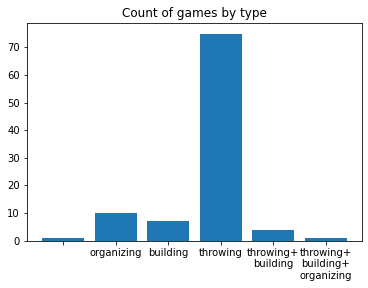

In [238]:
game_type_counts = stats_df.groupby(['is_throwing', 'is_building', 'is_organizing']).size().reset_index().rename(columns={0: 'num'})
print(game_type_counts)

labels = []
values = []
for index, row in game_type_counts.iterrows():
    elements = []
    if row.is_throwing: elements.append('throwing') 
    if row.is_building: elements.append('building') 
    if row.is_organizing: elements.append('organizing') 
    labels.append('+\n'.join(elements))
    values.append(row.num)

x_values = np.arange(len(values))
plt.bar(x_values, values)
plt.xticks(x_values, labels=labels)
plt.title('Count of games by type')
plt.show()

In [30]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = '../figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        save_path = os.path.abspath(save_path)
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')


In [180]:
def _add_new_histogram_results(all_results, new_results, key):
    if isinstance(new_results, (list, tuple)):
        all_results[key].extend(new_results)
    else:
        all_results[key].append(new_results)


def _extract_histogram_data(df, group_by_col, row_value_func, split_group_by_values):
    results_by_key = defaultdict(list)

    for _, row in df.iterrows():
        group_by_key = row[group_by_col]
        row_values = row_value_func(row)

        # single key
        if isinstance(group_by_key, (str, int)):
            _add_new_histogram_results(results_by_key, row_values, group_by_key)
        
        # multiple keys
        else:
            if split_group_by_values:
                for key in group_by_key:
                    _add_new_histogram_results(results_by_key, row_values, key)

            else:
                group_by_key = '_'.join(sorted(group_by_key))
                _add_new_histogram_results(results_by_key, row_values, group_by_key)

    return results_by_key


def _add_new_bar_chart_results(all_results, new_results, key):    
    if isinstance(new_results, (list, tuple)):
        for new_res in new_results:
            _add_new_bar_chart_results(all_results, new_res, key)

    elif isinstance(new_results, dict):
        for result_key in new_results:
            all_results[key][result_key] += new_results[result_key]

    elif isinstance(new_results, (str, int)):
        all_results[key][new_results] += 1
    
    else:
        raise ValueError(f'_add_new_bar_chart_results expected dict (or list/tuple of dicts), received {type(new_results)}: {new_results}')


def _extract_bar_chart_data(df, group_by_col, row_value_func, split_group_by_values, swap_outer_inner_keys=False):
    results_by_key = defaultdict(lambda: defaultdict(lambda: 0))

    for _, row in df.iterrows():
        group_by_key = row[group_by_col]
        row_values = row_value_func(row)

        # single key
        if isinstance(group_by_key, (str, int)):
            _add_new_bar_chart_results(results_by_key, row_values, group_by_key)
        
        # multiple keys
        else:
            if split_group_by_values:
                for key in group_by_key:
                    _add_new_bar_chart_results(results_by_key, row_values, key)

            else:
                group_by_key = '_'.join(sorted(group_by_key))
                _add_new_bar_chart_results(results_by_key, row_values, group_by_key)

    if swap_outer_inner_keys:
        swapped_results_by_key = defaultdict(lambda: defaultdict(lambda: 0))

        for outer_key, inner_dict in results_by_key.items():
            for inner_key, count in inner_dict.items():
                swapped_results_by_key[inner_key][outer_key] = count

        return swapped_results_by_key

    return results_by_key


def parallel_histograms(df, group_by_col, row_value_func, split_group_by_values=False,
    figsize=(16, 6), plot_density=True, title='',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16):

    results_by_key = _extract_histogram_data(df, group_by_col, row_value_func, split_group_by_values)

    global_min = min([min(values) for values in results_by_key.values() if len(values) > 0])
    global_max = max([max(values) for values in results_by_key.values() if len(values) > 0])

    fig, axes = plt.subplots(1, len(results_by_key), figsize=figsize)

    for index, key in enumerate(results_by_key):
        ax = axes[index]
        ax.hist(results_by_key[key], range=(global_min, global_max), density=plot_density)
        ax.set_title(key, fontsize=ax_title_fontsize)

        if index == 0:
             ax.set_ylabel('Density' if plot_density else 'Count', fontsize=ax_label_fontsize)
        else:
            ax.set_yticks([])
    

    if title:
        plt.suptitle(title, fontsize=super_title_fontsize)
    
    plt.show()


def single_ax_histograms(df, group_by_col, row_value_func, split_group_by_values=False,
    figsize=(8, 6), plot_density=False, stacked=True, title='', cmap='tab10', legend_loc='best', xlabel='',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16):

    results_by_key = _extract_histogram_data(df, group_by_col, row_value_func, split_group_by_values)
    keys = results_by_key.keys()
    values = [results_by_key[key] for key in keys]
    colormap = plt.cm.get_cmap(cmap)
    colors = [colormap(i) for i in range(len(keys))]

    plt.figure(figsize=figsize)
    plt.hist(values, label=list(keys), density=plot_density, stacked=stacked, color=colors)
    plt.legend(loc=legend_loc)
    plt.title(title, fontsize=super_title_fontsize)
    plt.ylabel('Density' if plot_density else 'Count', fontsize=ax_label_fontsize)
    plt.xlabel(xlabel, fontsize=ax_label_fontsize)    
    plt.show()


def single_ax_bar_chart(df, group_by_col, row_value_func, split_group_by_values=False, swap_outer_inner_keys=False, *,
    ax=None, figsize=(8, 6), title='', cmap='tab10',
    show_legend=True, legend_loc='best', legend_bbox_to_anchor=None, legend_from_color_dict_entries=False,
    xlabel='', ylabel='Count',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16,
    inner_key_order=None, outer_key_order=None, normalize_columns=False, vertical_bar_labels=False, 
    label_join_str=' +\n', color_dict=None, min_column_count_to_plot=None, min_category_count_to_plot=None,  
    save_path=None, print_save_latex=False):

    results_by_key = _extract_bar_chart_data(df, group_by_col, row_value_func, split_group_by_values, swap_outer_inner_keys)
    single_ax_bar_chart_from_results(results_by_key, ax=ax, figsize=figsize, title=title, cmap=cmap, 
        show_legend=show_legend, legend_loc=legend_loc, 
        legend_bbox_to_anchor=legend_bbox_to_anchor, legend_from_color_dict_entries=legend_from_color_dict_entries,
        xlabel=xlabel, ylabel=ylabel, super_title_fontsize=super_title_fontsize,
        ax_title_fontsize=ax_title_fontsize, ax_label_fontsize=ax_label_fontsize,
        inner_key_order=inner_key_order, outer_key_order=outer_key_order, 
        normalize_columns=normalize_columns, vertical_bar_labels=vertical_bar_labels, 
        label_join_str=label_join_str, color_dict=color_dict, 
        min_column_count_to_plot=min_column_count_to_plot, min_category_count_to_plot=min_category_count_to_plot,
        save_path=save_path, print_save_latex=print_save_latex)


def single_ax_bar_chart_from_results(results_by_key, *,
    ax=None, figsize=(8, 6), title='', cmap='tab10', 
    show_legend=True, legend_loc='best', legend_bbox_to_anchor=None, legend_from_color_dict_entries=False,
    xlabel='', ylabel='Count',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16, ax_tick_fontsize=12,
    inner_key_order=None, outer_key_order=None, normalize_columns=False, vertical_bar_labels=False, 
    label_join_str=' +\n', color_dict=None, min_column_count_to_plot=None, min_category_count_to_plot=None,  
    save_path=None, print_save_latex=False):

    if outer_key_order is None:
        outer_key_order = sorted(results_by_key.keys())

    if min_category_count_to_plot is not None:
        outer_key_sums = [sum(results_by_key[key].values()) for key in outer_key_order]
        print({key: sum for key, sum in zip(outer_key_order, outer_key_sums)})
        outer_key_order = [key for key, sum in zip(outer_key_order, outer_key_sums) if sum >= min_category_count_to_plot]

    if inner_key_order is None:
        inner_key_order =  sorted(set(
            [key for inner_keys in [list(x.keys()) for x in results_by_key.values()] 
            for key in inner_keys]
        ))

    if normalize_columns or min_column_count_to_plot:
        inner_key_sums = [sum([results_by_key[outer_key][inner_key] for outer_key in outer_key_order]) 
            for inner_key in inner_key_order]

        if min_column_count_to_plot:
            inner_key_order = [inner_key for inner_key, sum in zip(inner_key_order, inner_key_sums) 
                if sum >= min_column_count_to_plot]
            inner_key_sums = [sum for sum in inner_key_sums if sum >= min_column_count_to_plot]

        if normalize_columns:
            if ylabel == 'Count':
                ylabel = 'Proportion'

            if legend_bbox_to_anchor is None:
                legend_bbox_to_anchor = (1.0, 0.5)
                legend_loc = 'center left'

    if not vertical_bar_labels:
        inner_key_names = [key.replace('_', label_join_str) for key in inner_key_order]
    else:
        inner_key_names = inner_key_order

    colormap = plt.cm.get_cmap(cmap)
    if color_dict is None:
        colors = [colormap(i) for i in range(len(outer_key_order))]
    else:
        colors = [color_dict[key] for key in outer_key_order]

    should_show = False
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
        should_show = True

    current_start_values = np.zeros((len(inner_key_order,)))

    for index, outer_key in enumerate(outer_key_order):
        current_key_values = [results_by_key[outer_key][inner_key] for inner_key in inner_key_order]
        if normalize_columns:
            current_key_values = [x / y if x != 0 else x for x, y in zip(current_key_values, inner_key_sums)]

        # TODO: think about whether or not I want to support non-stacked
        ax.bar(inner_key_names, current_key_values, bottom=current_start_values, 
            label=outer_key, color=colors[index])
        current_start_values += np.array(current_key_values)

    if show_legend:
        if legend_from_color_dict_entries:
            legend_handles = [
                mpl.patches.Patch(color=color_dict[outer_key], edgecolor=color_dict[outer_key], label=outer_key)
                for outer_key in color_dict.keys()
            ]
            ax.legend(handles=legend_handles, bbox_to_anchor=legend_bbox_to_anchor, loc=legend_loc, prop=dict(size=ax_tick_fontsize))

        else:
            ax.legend(bbox_to_anchor=legend_bbox_to_anchor, loc=legend_loc, prop=dict(size=ax_tick_fontsize))
    ax.set_title(title, fontsize=super_title_fontsize)

    ax.set_xlabel(xlabel, fontsize=ax_label_fontsize)    
    ax.set_ylabel(ylabel, fontsize=ax_label_fontsize)
    
    bar_label_rotation = vertical_bar_labels
    if isinstance(bar_label_rotation, bool):
        bar_label_rotation = 90 if bar_label_rotation else 0

    ax.tick_params(axis='x', labelsize=ax_tick_fontsize, labelrotation=bar_label_rotation)
    ax.tick_params(axis='y', labelsize=ax_title_fontsize)
    
    if save_path is not None:
        save_plot(save_path, should_print=print_save_latex)

    if should_show:
        plt.show()


In [32]:
class CoocurrenceDefinition:
    def __init__(self, outer_key, inner_key, *,
        outer_primary_obj_only=True, inner_primary_obj_only=True, 
        use_categories_outer=False, use_categories_inner=False, name=None):

        self.outer_key = outer_key
        self.inner_key = inner_key
        self.outer_primary_obj_only = outer_primary_obj_only
        self.inner_primary_obj_only = inner_primary_obj_only
        self.use_categories_outer = use_categories_outer
        self.use_categories_inner = use_categories_inner

        if name is None:
            name_components = [outer_key]
            if not outer_primary_obj_only: name_components.append('all')
            if use_categories_outer: name_components.append('cat')
            name_components.append(inner_key)
            if not inner_primary_obj_only: name_components.append('all')
            if use_categories_inner: name_components.append('cat')
            name = '_'.join(name_components)

        self.name = name

SplitObjectPredicates = namedtuple(
    'SplitObjectPredicates', ('primary_objects', 'secondary_objects', 'predicates')
)

empty_coocurrence_dict = lambda: defaultdict(lambda: defaultdict(lambda: 0))

def update_coocurrence_dict(cooc_dict, outer_keys, inner_keys, omit_equals=False):
    for outer in outer_keys:
        for inner in inner_keys:
            if omit_equals and outer == inner:
                continue

            cooc_dict[outer][inner] += 1

def sort_by_count_desc(key_to_count):
    return [item[0] for item in sorted(key_to_count.items(), key=lambda item: item[1], reverse=True)]


def coocurrence_dict_to_matrix(cooc_dict):
    outer_key_counts = {key: sum(cooc_dict[key].values()) for key in cooc_dict}
    all_inner_keys = set([inner_key for keys in [inner_dict.keys() for inner_dict in cooc_dict.values()] for inner_key in keys])
    inner_key_counts = {inner_key: sum([cooc_dict[outer_key][inner_key] for outer_key in cooc_dict]) for inner_key in all_inner_keys}

    sorted_outer_keys = sort_by_count_desc(outer_key_counts)
    sorted_inner_keys = sort_by_count_desc(inner_key_counts)

    cooc_mat = np.zeros((len(sorted_outer_keys), len(sorted_inner_keys)))
    for i, outer in enumerate(sorted_outer_keys):
        for j, inner in enumerate(sorted_inner_keys):
            cooc_mat[i, j] = cooc_dict[outer][inner]

    return cooc_mat, sorted_outer_keys, sorted_inner_keys


def separate_objects_and_predicates(objects_with_predicates_list):
    primary_objects = []
    secondary_objects = []
    predicates = []

    if isinstance(objects_with_predicates_list, list):
        for object_with_predicates in objects_with_predicates_list:
            primary_objects.append(object_with_predicates['object'])

            if 'predicates' in object_with_predicates:
                for predicate_desc in object_with_predicates['predicates']:
                    if 'object' in predicate_desc:
                        secondary_objects.append(predicate_desc['object'])

                    if 'predicate' in predicate_desc:
                        predicates.append(predicate_desc['predicate'])

    return SplitObjectPredicates(primary_objects, secondary_objects, predicates)


def extract_all_coocurrences(df, column_prefix, coocurrence_defs, type_to_category_mapping=TYPES_TO_CATEGORIES):
    relevant_columns = list(filter(lambda c: c.startswith(f'{column_prefix}_'), df.columns))
    obj_with_pred_columns = list(filter(
        lambda c: any([isinstance(x, list) and isinstance(x[0], dict) for x in df[c]]), 
        relevant_columns))
    
    if any([cooc_def.name is None or cooc_def.inner_key is None or cooc_def.outer_key is None for cooc_def in coocurrence_defs]):
        raise ValueError(f'Received at least one cooc def without a name, inner key, or outer key: {coocurrence_defs}')

    coocurrence_dicts = {
        cooc_def.name: empty_coocurrence_dict()   
        for cooc_def in coocurrence_defs
    }

    for col in obj_with_pred_columns:
        coocurrence_dicts[f'{col}_object_predicate'] = empty_coocurrence_dict()
        coocurrence_dicts[f'{col}_object_object'] = empty_coocurrence_dict()

    for _, row in df.iterrows():
        row_values = {col: separate_objects_and_predicates(row[col]) if col in obj_with_pred_columns else row[col] for col in relevant_columns}

        # compute predefined coocurrences
        for cooc_def in coocurrence_defs:
            outer_col = f'{column_prefix}_{cooc_def.outer_key}'
            inner_col = f'{column_prefix}_{cooc_def.inner_key}'

            outer_values = row_values[outer_col]
            inner_values = row_values[inner_col]

            if outer_col in obj_with_pred_columns:
                if cooc_def.outer_primary_obj_only:
                    outer_values = outer_values.primary_objects[:]
                else:
                    outer_values = outer_values.primary_objects + outer_values.secondary_objects

            if cooc_def.use_categories_outer:
                outer_values = [type_to_category_mapping[val] for val in outer_values]

            if inner_col in obj_with_pred_columns:
                if cooc_def.inner_primary_obj_only:
                    inner_values = inner_values.primary_objects[:]
                else:
                    inner_values = inner_values.primary_objects + inner_values.secondary_objects

            if cooc_def.use_categories_inner:
                inner_values = [type_to_category_mapping[val] for val in inner_values]

            update_coocurrence_dict(coocurrence_dicts[cooc_def.name], outer_values, inner_values)

        # compute generic object-object and object-predicate coocurrences
        for col in obj_with_pred_columns:
            if isinstance(row[col], list):
                for object_with_predicates in row[col]:
                    first_object = object_with_predicates['object']
                    if 'predicates' in object_with_predicates:
                        for predicate_desc in object_with_predicates['predicates']:
                            second_object = None
                            if 'object' in predicate_desc:
                                second_object = predicate_desc['object']
                                coocurrence_dicts[f'{col}_object_object'][first_object][second_object] += 1
                                coocurrence_dicts[f'{col}_object_object'][second_object][first_object] += 1

                            if 'predicate' in predicate_desc:
                                predicate = predicate_desc['predicate']
                                
                                coocurrence_dicts[f'{col}_object_predicate'][first_object][predicate] += 1
                                if second_object:
                                    coocurrence_dicts[f'{col}_object_predicate'][second_object][predicate] += 1

    # combine the individual object-predicate coocurrences to the combined ones
    coocurrence_dicts['all_object_predicate'] = empty_coocurrence_dict()
    coocurrence_dicts['all_object_object'] = empty_coocurrence_dict()

    for col in obj_with_pred_columns:
        for template in '{key}_object_predicate', '{key}_object_object':
            overall_cooc_dict = coocurrence_dicts[template.format(key='all')]
            current_cooc_dict = coocurrence_dicts[template.format(key=col)]

            for outer_key in current_cooc_dict:
                for inner_key in current_cooc_dict[outer_key]:
                    overall_cooc_dict[outer_key][inner_key] += current_cooc_dict[outer_key][inner_key]

    return coocurrence_dicts


def plot_coocurrence_data(cooc_dict, title='', xlabel='', ylabel='', figsize=(12, 12),
    title_fontsize=24, ax_label_fontsize=20, tick_fontsize=16, cmap='gist_yarg'): 
    cooc_mat, outer_keys, inner_keys = coocurrence_dict_to_matrix(cooc_dict)

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    plt.imshow(cooc_mat, cmap=cmap)

    plt.xticks(np.arange(len(inner_keys)), inner_keys, rotation='vertical', fontsize=tick_fontsize)
    ax.xaxis.set_ticks_position('top')
    # ax.xaxis.set_label_position('top')
    plt.yticks(np.arange(len(outer_keys)), outer_keys, fontsize=tick_fontsize)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=tick_fontsize)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=ax_label_fontsize)
    plt.ylabel(ylabel, fontsize=ax_label_fontsize)
    plt.show()




# Potentially relevant plots to the paper

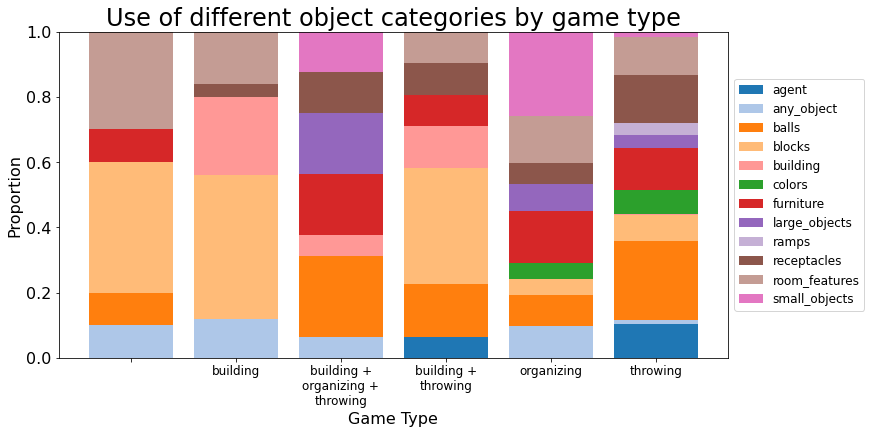

In [142]:
object_colormap = plt.cm.get_cmap('tab20')
OBJECT_CATEGORY_TO_COLOR = {obj_category: object_colormap(i) for i, obj_category in enumerate(CATEGORIES_TO_TYPES)}

minimal_object_colormap = plt.cm.get_cmap('tab10')
MINIMAL_CATEGORIES = (
    AGENT, ANY_OBJECT, BALLS, BLOCKS, BUILDING, FURNITURE, 
    LARGE_OBJCETS, RAMPS, RECEPTACLES, ROOM_FEATURES, SMALL_OBJECTS
)
MINIMAL_OBJECT_CATEGORY_TO_COLOR = {
    obj_category: minimal_object_colormap(i - 1) if i > 0 else (0, 0, 0, 1)
    for i, obj_category in enumerate(MINIMAL_CATEGORIES)
}

single_ax_bar_chart(stats_df, 'game_type', lambda row: row.object_categories_referenced, swap_outer_inner_keys=True,
    title='Use of different object categories by game type', xlabel='Game Type', figsize=(12, 6), 
    color_dict=OBJECT_CATEGORY_TO_COLOR, normalize_columns=True, save_path='object_categories_by_game_type.png')


{'agent': 87, 'any_object': 85, 'balls': 718, 'blocks': 358, 'building': 52, 'colors': 15, 'furniture': 145, 'large_objects': 103, 'ramps': 28, 'receptacles': 168, 'room_features': 123, 'small_objects': 74}


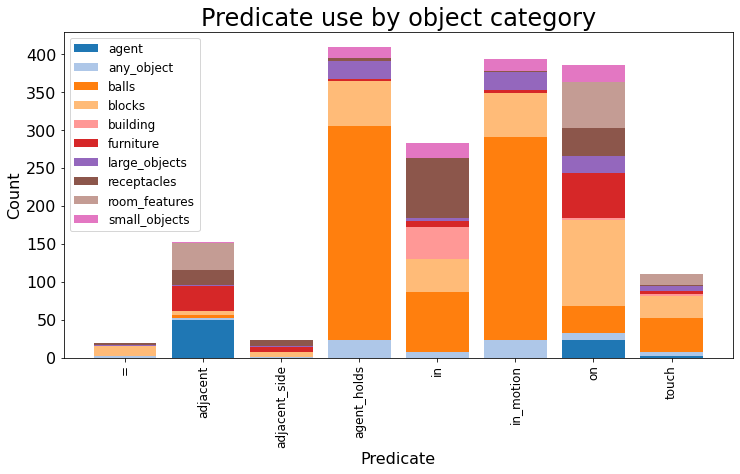

In [132]:
# we want the outer keys to be the stacked labels colored differently (in this case, the object categories)
# and the inner keys to the things that appear on the x axis (in this case, the predicates)


def combine_nested_dict_results(df, nested_dict_field):
    combined_results = defaultdict(lambda: defaultdict(lambda: 0))
    for row_results in df[nested_dict_field]:
        for outer_key, inner_results in row_results.items():
            _add_new_bar_chart_results(combined_results, inner_results, outer_key)


    return combined_results

category_to_predicate_results_all_games = combine_nested_dict_results(stats_df, 'category_to_pred_counts')

single_ax_bar_chart_from_results(category_to_predicate_results_all_games, 
    title='Predicate use by object category', xlabel='Predicate', figsize=(12, 6), legend_loc='upper left',
    vertical_bar_labels=True, color_dict=OBJECT_CATEGORY_TO_COLOR, min_column_count_to_plot=20,
    min_category_count_to_plot=30,
)


{'any_object': 54, 'balls': 8, 'blocks': 106, 'building': 29, 'furniture': 19, 'large_objects': 10, 'receptacles': 9, 'room_features': 27, 'small_objects': 20}
{'agent': 87, 'any_object': 31, 'balls': 710, 'blocks': 252, 'building': 23, 'colors': 15, 'furniture': 126, 'large_objects': 93, 'ramps': 28, 'receptacles': 159, 'room_features': 96, 'small_objects': 54}


/var/folders/j9/9f76zhzd1ldf1jcmp7t_70q00000gn/T/ipykernel_2582/3701403670.py:222: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpl.patches.Patch(color=color_dict[outer_key], edgecolor=color_dict[outer_key], label=outer_key)


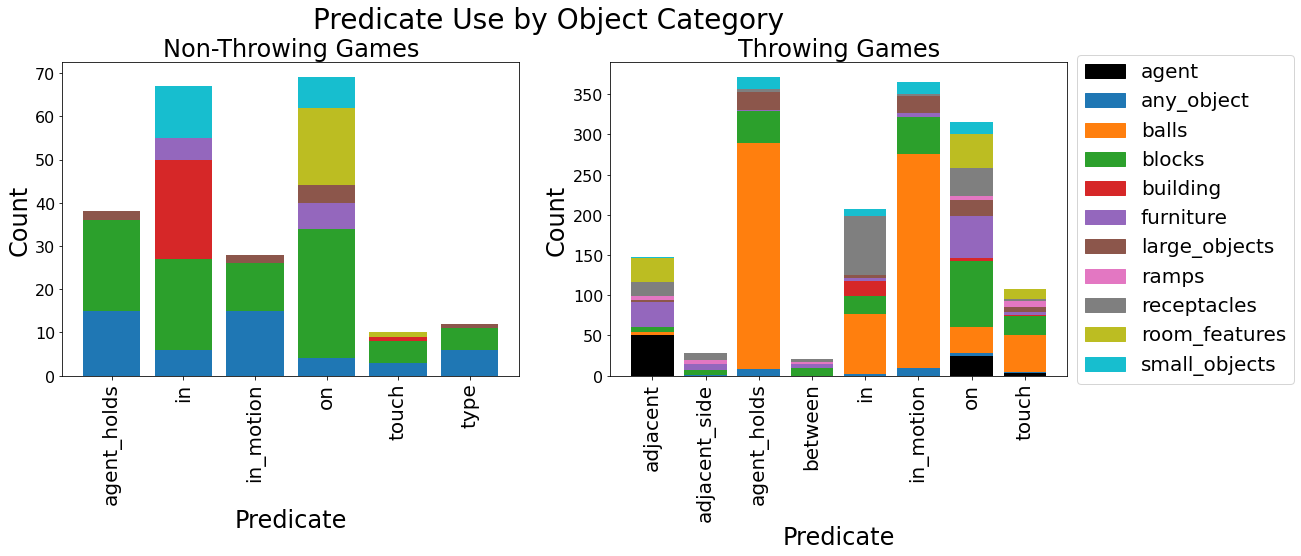

In [247]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(18, 6))
fig.subplots_adjust(top=0.85)

category_to_predicate_results_throwing = combine_nested_dict_results(stats_df.loc[stats_df.is_throwing, :], 'category_to_pred_counts')
category_to_predicate_results_non_throwing = combine_nested_dict_results(stats_df.loc[~stats_df.is_throwing, :], 'category_to_pred_counts')

suptitle_fontsize = 28
ax_label_fontsize = 24
ax_tick_fontsize = 20


single_ax_bar_chart_from_results(category_to_predicate_results_non_throwing, 
    title='Non-Throwing Games', xlabel='Predicate', ax=left_ax,
    vertical_bar_labels=90, label_join_str='_\n',
    color_dict=MINIMAL_OBJECT_CATEGORY_TO_COLOR, 
    show_legend=False,
    min_column_count_to_plot=10, min_category_count_to_plot=10,
    ax_label_fontsize=ax_label_fontsize, ax_tick_fontsize=ax_tick_fontsize
    # save_path='non_throwing_predicate_use_by_object_category.png'
)


single_ax_bar_chart_from_results(category_to_predicate_results_throwing, ax=right_ax,
    title='Throwing Games', xlabel='Predicate', 
    vertical_bar_labels=90, label_join_str='_\n', 
    legend_bbox_to_anchor=(1.0, 0.5), legend_loc='center left', legend_from_color_dict_entries=True,
    color_dict=MINIMAL_OBJECT_CATEGORY_TO_COLOR, 
    min_column_count_to_plot=20, min_category_count_to_plot=20, 
    ax_label_fontsize=ax_label_fontsize, ax_tick_fontsize=ax_tick_fontsize,
    # save_path='throwing_only_predicate_use_by_object_category.png'     
)

plt.suptitle('Predicate Use by Object Category', fontsize=suptitle_fontsize)

save_plot('side_by_side_predicate_use_by_object_category_vertical_labels.pdf')

plt.show()

In [240]:
{key: category_to_predicate_results_non_throwing[key]['agent'] for key in category_to_predicate_results_non_throwing}

{'building': 0,
 'blocks': 0,
 'room_features': 0,
 'any_object': 0,
 'balls': 0,
 'furniture': 0,
 'receptacles': 0,
 'large_objects': 0,
 'small_objects': 0}

{'agent': 85, 'any_object': 23, 'balls': 646, 'blocks': 172, 'building': 5, 'colors': 15, 'furniture': 110, 'large_objects': 90, 'ramps': 28, 'receptacles': 143, 'room_features': 92, 'small_objects': 52}


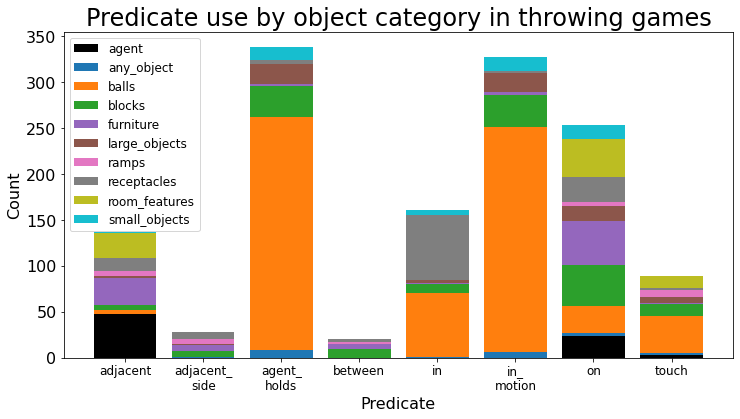

In [153]:
category_to_predicate_results_throwing = combine_nested_dict_results(stats_df.loc[stats_df.game_type_str == 'throwing', :], 'category_to_pred_counts')


single_ax_bar_chart_from_results(category_to_predicate_results_throwing, 
    title='Predicate use by object category in throwing games', xlabel='Predicate', figsize=(12, 6), 
    vertical_bar_labels=False, label_join_str='_\n',
    color_dict=MINIMAL_OBJECT_CATEGORY_TO_COLOR, min_column_count_to_plot=20,
    min_category_count_to_plot=20,
    save_path='throwing_only_predicate_use_by_object_category.png'     
)

{'any_object': 54, 'balls': 8, 'blocks': 106, 'building': 29, 'furniture': 19, 'large_objects': 10, 'receptacles': 9, 'room_features': 27, 'small_objects': 20}


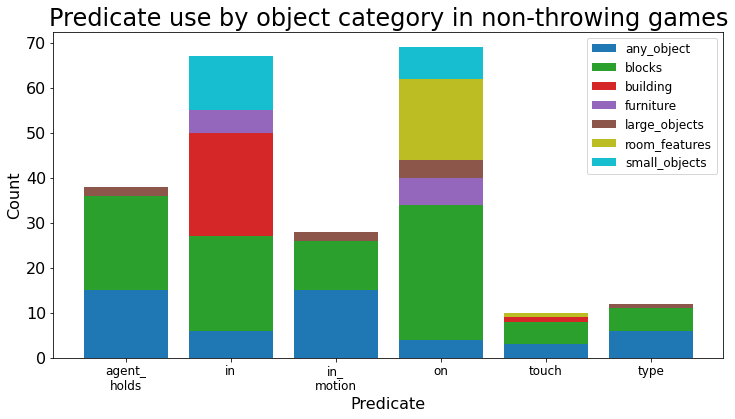

In [145]:


category_to_predicate_results_building = combine_nested_dict_results(stats_df.loc[~stats_df.is_throwing, :], 'category_to_pred_counts')

single_ax_bar_chart_from_results(category_to_predicate_results_building, 
    title='Predicate use by object category in non-throwing games', xlabel='Predicate', figsize=(12, 6), 
    vertical_bar_labels=False, label_join_str='_\n',
    color_dict=MINIMAL_OBJECT_CATEGORY_TO_COLOR, 
    min_column_count_to_plot=10, min_category_count_to_plot=10,
    save_path='non_throwing_predicate_use_by_object_category.png'
)

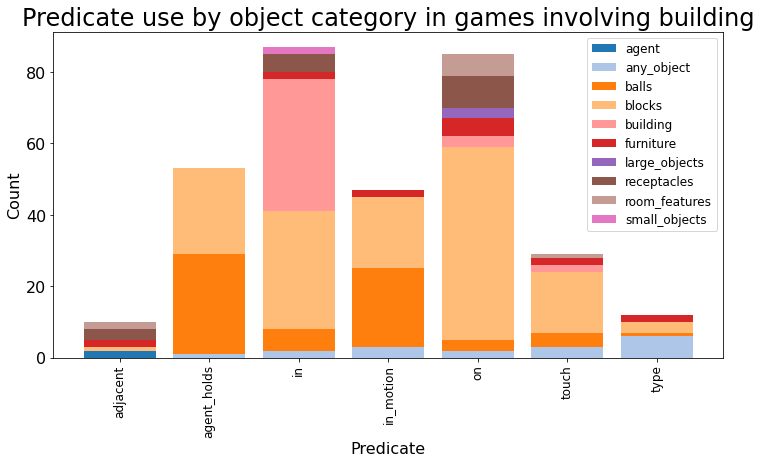

In [37]:
category_to_predicate_results_building = combine_nested_dict_results(stats_df.loc[stats_df.is_building, :], 'category_to_pred_counts')

single_ax_bar_chart_from_results(category_to_predicate_results_building, 
    title='Predicate use by object category in games involving building', xlabel='Predicate', figsize=(12, 6), 
    vertical_bar_labels=True, color_dict=OBJECT_CATEGORY_TO_COLOR, min_column_count_to_plot=10,
    save_path='all_building_predicate_use_by_object_category.png'
)

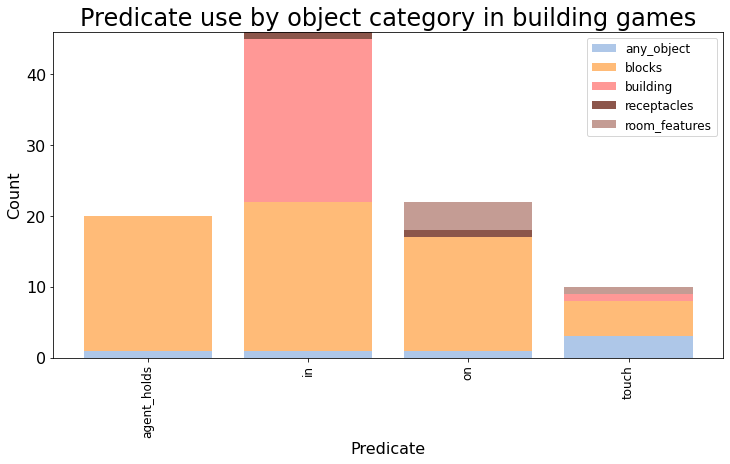

In [38]:
category_to_predicate_results_throwing = combine_nested_dict_results(stats_df.loc[stats_df.game_type_str == 'building', :], 'category_to_pred_counts')


single_ax_bar_chart_from_results(category_to_predicate_results_throwing, 
    title='Predicate use by object category in building games', xlabel='Predicate', figsize=(12, 6), 
    vertical_bar_labels=True, color_dict=OBJECT_CATEGORY_TO_COLOR, min_column_count_to_plot=10,
    save_path='building_only_predicate_use_by_object_category.png'    
)

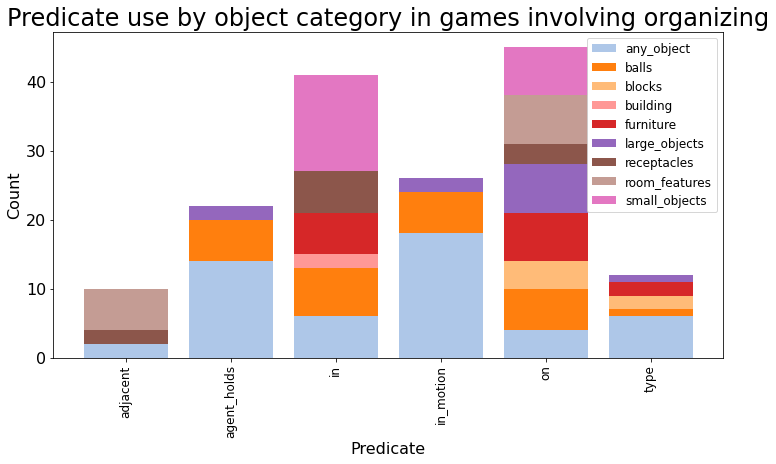

In [39]:
category_to_predicate_results_organizing = combine_nested_dict_results(stats_df.loc[stats_df.is_organizing, :], 'category_to_pred_counts')

single_ax_bar_chart_from_results(category_to_predicate_results_organizing, 
    title='Predicate use by object category in games involving organizing', xlabel='Predicate', figsize=(12, 6),  
    vertical_bar_labels=True, color_dict=OBJECT_CATEGORY_TO_COLOR, min_column_count_to_plot=10,
    save_path='all_organizing_predicate_use_by_object_category.png'
)

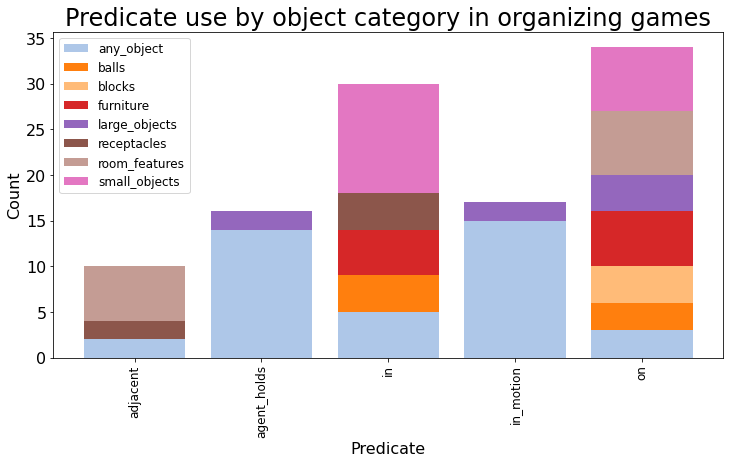

In [40]:
category_to_predicate_results_throwing = combine_nested_dict_results(stats_df.loc[stats_df.game_type_str == 'organizing', :], 'category_to_pred_counts')


single_ax_bar_chart_from_results(category_to_predicate_results_throwing, 
    title='Predicate use by object category in organizing games', xlabel='Predicate', figsize=(12, 6), 
    vertical_bar_labels=True, color_dict=OBJECT_CATEGORY_TO_COLOR, min_column_count_to_plot=10,
    save_path='organizing_only_predicate_use_by_object_category.png'
)

## Context sensitivity analyses

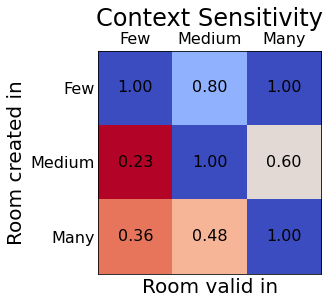

In [242]:
room_name_validity_matrix = np.zeros((len(ROOM_NAMES), len(ROOM_NAMES)))
for i, room_name in enumerate(ROOM_NAMES):
    for j, other_room_name in enumerate(ROOM_NAMES):
        room_name_validity_matrix[i, j] = len(stats_df.loc[(stats_df.room_name == room_name) & [other_room_name in rooms for rooms in stats_df.game_valid_rooms]])

    room_name_validity_matrix[i, :] /= room_name_validity_matrix[i, i]

inner_fontsize = 16
outer_fontsize = 20
title_fontsize = 24

plt.matshow(room_name_validity_matrix, cmap='coolwarm_r')

# plt.colorbar()
tick_locs = np.arange(len(ROOM_NAMES))
# tick_labels = tick_locs + 1
tick_labels = ROOM_NAMES
plt.xticks(tick_locs, tick_labels, fontsize=inner_fontsize) # , rotation='vertical')
plt.yticks(tick_locs, tick_labels, fontsize=inner_fontsize)

ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0)

for (i, j), p in np.ndenumerate(room_name_validity_matrix):
    ax.text(j, i, '{:0.2f}'.format(p), ha='center', va='center', 
        size=inner_fontsize)

plt.xlabel('Room valid in', fontsize=outer_fontsize)
plt.ylabel('Room created in', fontsize=outer_fontsize)
plt.title('Context Sensitivity', fontsize=title_fontsize)

save_plot('context_sensitivity_validity_matrix.pdf')

Text(0.5, 1.0, 'Abstract Structure Frequency')

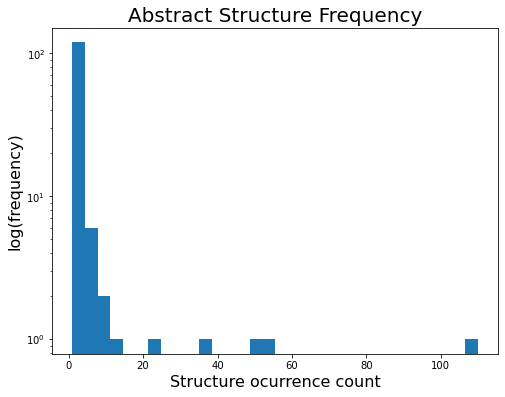

In [121]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
repeated_structures_df.hist(column='count', ax=ax, grid=False, bins=32)
ax.set_yscale('log')
plt.ylabel('log(frequency)', fontsize=16)
plt.xlabel('Structure ocurrence count', fontsize=16)
plt.title('Abstract Structure Frequency', fontsize=20)
# plt.suptitle('Repeated structure count')

[0, 1, 3, 7, 15, 31, 63, 127, 132]


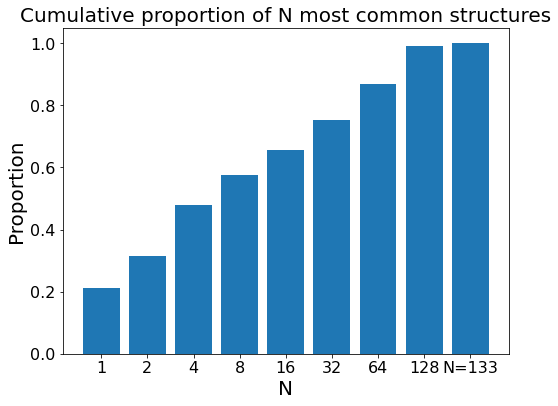

In [246]:
repeated_structures_by_count = repeated_structures_df.sort_values('count', ascending=False)

plt.figure(figsize=(8, 4))
ax = plt.gca()

s = repeated_structures_by_count['count'].cumsum() / repeated_structures_by_count['count'].sum()

max_pow = int(np.floor(np.log2(len(s))))
powers = [2 ** pow - 1 for pow in range(max_pow + 1)]
bar_indices = powers + [len(s) - 1]
print(bar_indices)

s_arr = np.array(s)
bar_locs = np.arange(len(bar_indices))
plt.bar(bar_locs, s_arr[bar_indices])

ax_tick_fontsize = 16
ax_label_fontsize = 20
title_fontsize = 20


plt.ylabel('Proportion', fontsize=ax_label_fontsize)
plt.xlabel('N', fontsize=ax_label_fontsize)
plt.title('Cumulative proportion of N most common structures', fontsize=title_fontsize)
# plt.ylim(0, 1)
plt.xticks(bar_locs, [str(pow + 1) for pow in powers] + [f'N={len(s)}'], fontsize=ax_tick_fontsize)
plt.yticks(fontsize=ax_tick_fontsize)


save_plot('common_structures_short.pdf')

plt.show()

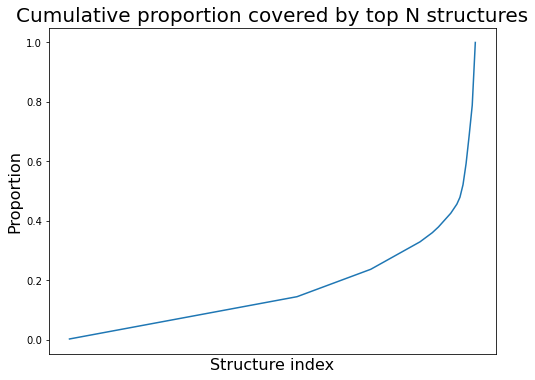

In [123]:
repeated_structures_by_count = repeated_structures_df.sort_values('count')

plt.figure(figsize=(8, 6))
ax = plt.gca()

s = repeated_structures_by_count['count'].cumsum() / repeated_structures_by_count['count'].sum()

# s.plot(kind='bar', ax=ax, grid=False)

plt.plot(np.arange(len(s)), s)

plt.ylabel('Proportion', fontsize=16)
plt.xlabel('Structure index', fontsize=16)
plt.title('Cumulative proportion covered by top N structures', fontsize=20)
# plt.ylim(0, 1)

ax.get_xaxis().set_ticks([])

plt.show()


# plt.suptitle('Repeated structure count')

In [206]:
repeated_structures_by_count = repeated_structures_df.sort_values('count', ascending=False)
total = repeated_structures_df['count'].sum()
print(total)

print(repeated_structures_by_count['count'].head(4).sum() / total)
print(repeated_structures_df.loc[repeated_structures_df['count'] <= 1, 'count'].sum() / total)
print(repeated_structures_df.loc[repeated_structures_df['count'] <= 1, 'count'].count() / len(repeated_structures_by_count))
print(repeated_structures_df.loc[repeated_structures_df['count'] <= 2, 'count'].count() / len(repeated_structures_by_count))

520
0.47884615384615387
0.14423076923076922
0.5639097744360902
0.7443609022556391


In [210]:
(repeated_structures_by_count['count'] == 1).sum() / len(repeated_structures_by_count) 

0.5639097744360902

# Between-game-type visualizations


In [ ]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.ast_nodes, 
    title='Total AST nodes by game type', xlabel='Total AST nodes', legend_loc='upper right')

In [ ]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.setup_nodes, 
    title='Total setup nodes by game type', xlabel='Total setup nodes', legend_loc='upper right')

In [ ]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.max_depth, 
    title='Max depth by game type', xlabel='Max depth', legend_loc='upper right')

In [ ]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.num_preferences, 
    title='Number of preferences by game type', xlabel='# of preferences', legend_loc='upper right')

In [ ]:
def extract_num_types_referenced(row):
    if isinstance(row.object_types_referenced, dict):
        return len(row.object_types_referenced)

    return 0


single_ax_histograms(stats_df, 'game_type', extract_num_types_referenced, 
    title='Total number of types referenced by game type', xlabel='# of types', legend_loc='upper right')

In [ ]:
def extract_num_categories_referenced(row):
    if isinstance(row.object_categories_referenced, dict):
        return len(row.object_categories_referenced)

    return 0


single_ax_histograms(stats_df, 'game_type', extract_num_categories_referenced, 
    title='Total number of object categories referenced by game type', xlabel='# of categories', legend_loc='upper right')

In [ ]:
def extract_predicates_referenced(row):
    if isinstance(row.predicates_referenced, dict):
        return len(row.predicates_referenced)

    return 0


single_ax_histograms(stats_df, 'game_type', extract_predicates_referenced, 
    title='Total number of predicates referenced by game type', xlabel='# of predicates', 
    legend_loc='upper left')

In the next two plots, and the two plots that follow, I plot references to types (in the first two) and predicates (in the second two) by game type. The first of each two plots counts individual references to each type (so if a game refers to a type three times, it adds 3), while the second of each two plots counts how many games refer to each type (so hthe same game referring to a type three times will only add 1).

In [ ]:
single_ax_bar_chart(stats_df, 'game_type', lambda row: row.object_types_referenced,
    title='Total object type references by game type', xlabel='Object type', figsize=(12, 6))


In [ ]:
def dict_keys_to_1(row):
    if isinstance(row.object_types_referenced, dict):
        return {key: 1 for key in row.object_types_referenced}

single_ax_bar_chart(stats_df, 'game_type', dict_keys_to_1,
    title='Count of games referring to each object type', xlabel='Object type', figsize=(12, 6))


In [ ]:
single_ax_bar_chart(stats_df, 'game_type', lambda row: row.predicates_referenced,
    title='Total predicate references by game type', xlabel='Predicate', figsize=(12, 6))


In [ ]:
def dict_keys_to_1(row):
    if isinstance(row.predicates_referenced, dict):
        return {key: 1 for key in row.predicates_referenced}

single_ax_bar_chart(stats_df, 'game_type', dict_keys_to_1,
    title='Count of games referring to each predicate', xlabel='Predicate', figsize=(12, 6))


# Throwing game visualizations

* The fiirst set of plots visualize coocurrence matrices between different game elmenets. For example:
    * Thrown object <> thrown game goal (to get something in, on, to hit another object, etc.)
    * Thrown object <> target object coocurrence
    * Coocurrences between various types of objects in the thrown game schema (the object thrown to, the object thrown from, objects and predicates, etc.)
* **In all of these, I don't currently control for the fact that same objects appear in more of the rooms -- I could count how many games I have in each room, note which objects appear in each room, and account for that in my analysis, right?**
* I can also generate analyses for throwing games like the analyses I generated for all games above. I'll generate a few of those plots, to give some examples, below the cocourrence matrices. Some of the things I could plot include:
    * Number of preferences?
    * Average length/depth of preferences?
    * Max depth?
    * Total type references
    * Number of types referenced
    * **Would complexity of the setup be an interesting thing to quantify?**

In [ ]:
throwing_df = stats_df[stats_df.is_throwing == 1]

throwing_df.head()

In [ ]:
THROWING_COOCURRENCE_DEFINITIONS = (
    CoocurrenceDefinition('objects', 'goal'),
    CoocurrenceDefinition('objects', 'goal', use_categories_outer=True),
    CoocurrenceDefinition('objects', 'to'),
    CoocurrenceDefinition('objects', 'to', use_categories_inner=True),
    CoocurrenceDefinition('objects', 'on'),
    CoocurrenceDefinition('objects', 'on', use_categories_inner=True),
    CoocurrenceDefinition('goal', 'to'),
    CoocurrenceDefinition('goal', 'to', use_categories_inner=True),
    CoocurrenceDefinition('on', 'to'),
    CoocurrenceDefinition('from', 'to', outer_primary_obj_only=False, inner_primary_obj_only=False),
)

throwing_coocurrences = extract_all_coocurrences(throwing_df, 'throwing', THROWING_COOCURRENCE_DEFINITIONS)

throwing_coocurrences.keys()

In [ ]:
plot_coocurrence_data(throwing_coocurrences['objects_cat_goal'], 
    'Thrown category <> goal cocurrence', 'Goal', 'Thrown Object Category', (8, 8))

In [ ]:
plot_coocurrence_data(throwing_coocurrences['objects_goal'], 
    'Thrown object <> goal cocurrence', 'Goal', 'Thrown Object', (6, 8))

In [ ]:
plot_coocurrence_data(throwing_coocurrences['objects_to'], 
    'Thrown object <> target object cocurrence', 'Object', 'Thrown Object', (12, 6), cmap='gist_yarg')

In [ ]:
plot_coocurrence_data(throwing_coocurrences['objects_to_cat'], 
    'Thrown object <> target object category', 'Object Category', 'Thrown Object', (6, 8))

In [ ]:
plot_coocurrence_data(throwing_coocurrences['goal_to'], 
    'Goal <> target object cocurrence', 'Target Object', 'Goal', (12, 4), cmap='gist_yarg')

In [ ]:
plot_coocurrence_data(throwing_coocurrences['goal_to_cat'], 
    'Goal <> target object category', 'Target Object Category', 'Goal', (12, 4), cmap='gist_yarg')

In [ ]:
plot_coocurrence_data(throwing_coocurrences['on_to'], 
    'On object <> target object cocurrence', 'Target Object', 'On Object', (12, 4), cmap='gist_yarg')

In [ ]:
plot_coocurrence_data(throwing_coocurrences['from_to'], 
    'From object <> target object cocurrence', 'Target Object', 'From Object', (12, 4), cmap='gist_yarg')

In [ ]:
plot_coocurrence_data(throwing_coocurrences['all_object_predicate'], 
    'Object <> predicate cocurrence', 'Predicate', 'Object', (12, 8), cmap='gist_yarg')

In [ ]:
plot_coocurrence_data(throwing_coocurrences['all_object_object'], 
    'Object <> object cocurrence', 'Object', 'Object', (12, 12), cmap='gist_yarg')

## Throwing game bar charts

In [ ]:
def dict_keys_to_1(row):
    if isinstance(row.object_types_referenced, dict):
        return {key: 1 for key in row.object_types_referenced}

single_ax_bar_chart(throwing_df, 'throwing_goal', dict_keys_to_1,
    title='Count of throwing games referring to each object type', xlabel='Object type', figsize=(12, 6))



In [ ]:
def dict_keys_to_1(row):
    if isinstance(row.predicates_referenced, dict):
        return {key: 1 for key in row.predicates_referenced}

single_ax_bar_chart(throwing_df, 'throwing_goal', dict_keys_to_1,
    title='Count of throwing games referring to each predicate', xlabel='Object type', figsize=(12, 6))



In [ ]:
single_ax_histograms(throwing_df, 'throwing_goal', lambda row: row.num_preferences, 
    title='Total number of preferneces by throwing game type', xlabel='# of preferences', legend_loc='upper right')

In [ ]:
single_ax_histograms(throwing_df, 'throwing_goal', lambda row: row.setup_nodes, 
    title='Total setup nodes by throwing game type', xlabel='Total setup nodes', legend_loc='upper right')

In [ ]:
building_df_or_organizing_df = stats_df[np.logical_or(stats_df.is_building == 1, stats_df.is_organizing == 1)]
building_df = stats_df[stats_df.is_building == 1]
organizing_df = stats_df[stats_df.is_organizing == 1]
non_throwing_df = stats_df[stats_df.is_throwing == 0]

len(building_df_or_organizing_df), len(building_df), len(organizing_df), len(non_throwing_df)

## Non-throwing game statistics

See the above cell -- we have a total of 9 games that don't involve any throwing, or alternatively, a total of 13 games that involve either building or organizing. 

**Is this enough to separately extract statistics over? Or too little? If yes, anything specific we want to see?**

In [211]:
stats_df.room.value_counts()

0    35
2    33
1    30
Name: room, dtype: int64

In [226]:
stats_df_by_node = stats_df.sort_values('ast_nodes')
dup_values = stats_df_by_node.ast_nodes.duplicated(False)

stats_df_by_node.loc[dup_values , ['game_name', 'ast_nodes', 'game_type']].head(30)

,game_name,ast_nodes,game_type
14,613e4bf960ca68f8de00e5e7,18,[building]
26,614e1599db14d8f3a5c1486a,18,[organizing]
31,614fb15adc48d3f9ffcadd41,20,[throwing]
78,60a6ba026f8bd75b67b23c97,20,[throwing]
68,5ba855d47c0ebe0001272f70,20,[throwing]
71,6172378d423fdf1acdc2d212,21,[throwing]
42,5ff4a242cbe069bc27d9278b,21,[throwing]
66,616da508e4014f74f43c8433,21,[throwing]
30,616abb33ebe1d6112545f76d,23,[throwing]
3,5bc79f652885710001a0e82a,23,[throwing]


In [ ]:
sorted_df = stats_df.sort_values('ast_nodes')
sorted_df.loc[(sorted_df.is_throwing == 1) & (sorted_df.setup_nodes > 0), ['game_name', 'ast_nodes', 'game_type']]

In [251]:
sorted_df = stats_df.sort_values('ast_nodes')
sorted_df.loc[sorted_df.is_throwing == 1, ['game_name', 'room_name', 'ast_nodes', 'game_type']].head(30)

,game_name,room_name,ast_nodes,game_type
31,614fb15adc48d3f9ffcadd41,Many,20,[throwing]
78,60a6ba026f8bd75b67b23c97,Many,20,[throwing]
68,5ba855d47c0ebe0001272f70,Many,20,[throwing]
71,6172378d423fdf1acdc2d212,Many,21,[throwing]
42,5ff4a242cbe069bc27d9278b,Few,21,[throwing]
66,616da508e4014f74f43c8433,Many,21,[throwing]
30,616abb33ebe1d6112545f76d,Medium,23,[throwing]
3,5bc79f652885710001a0e82a,Few,23,[throwing]
80,5b6a87d2cda8590001db8e07,Medium,23,[throwing]
86,6106ac34408681f3b0d07396,Few,27,[throwing]


In [ ]:
stats_df.object_types_referenced

In [ ]:
repeated_structures_df.head()

Text(0.5, 0, 'Reference count')

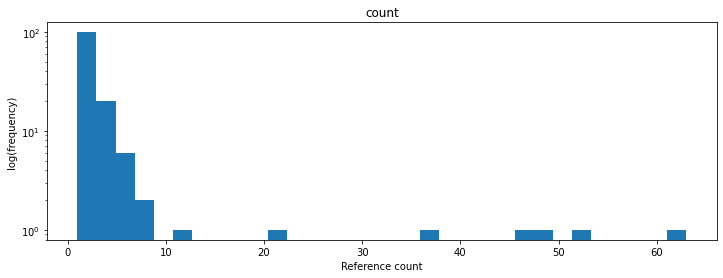

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def edit_distance_matrix(structure_df):
    distances = np.zeros((len(structure_df), len(structure_df)))
    for i, structure in enumerate(structure_df.structure):
        for j, other_structure in enumerate(structure_df.structure):
            distances[i, j] = editdistance.eval(structure, other_structure)

    return distances


def edit_distance_and_dendrogram(structure_df):
    distances = edit_distance_matrix(repeated_structures_df)
    plt.figure(figsize=(8, 8))
    plt.imshow(distances, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.show()

    square_distances = squareform(distances)
    linkage_matrix = linkage(square_distances, "single")

    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix)
    plt.show()

edit_distance_and_dendrogram(repeated_structures_df)

In [ ]:
repeated_structures_df.sort_values('count', ascending=False).head(10)

In [ ]:
repeated_structures_df[repeated_structures_df.structure_start != 'hold-while' ]['count'].sum()

In [ ]:
repeated_structures_df[(repeated_structures_df.structure_start != 'hold-while') & (repeated_structures_df['count'] == 2)].shape

In [ ]:
148 / 260